In [464]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import matplotlib.patches as mpatches
#%matplotlib inline
#%matplotlib osx
plt.ioff() # Turn interactive plotting off
url = "https://raw.githubusercontent.com/jamcro/shootGaze/master/data/shootingNoviceGaze.csv"
gaze_df = pd.read_csv(url, sep=',', skipinitialspace=True)
url = "https://raw.githubusercontent.com/jamcro/shootGaze/master/data/shootingNoviceKinematics.csv"
kin_df = pd.read_csv(url, sep=',', skipinitialspace=True)

HTTPError: HTTP Error 404: Not Found

In [447]:
gaze_df.head(2)

,Subject,Intervention,Day,Trial,Timer,startTime,finishTime,Category,Position,Distance,Shot
0,1,0,1,1,7.05,7.685,8.722,B,2.0,5.0,0
1,1,0,1,1,7.05,8.790,9.419,A,1.0,5.0,0


In [448]:
#gaze_df['fixOn'] = (gaze_df.startTime - gaze_df.Timer)
#gaze_df['fixOff'] = (gaze_df.finishTime - gaze_df.Timer)
#gaze_df['fixLen'] = (gaze_df.fixOff - gaze_df.fixOn)

# put them in order to make table easier to view
gaze_df.insert(7, 'fixOn', (gaze_df.startTime - gaze_df.Timer))
gaze_df.insert(8, 'fixOff', (gaze_df.finishTime - gaze_df.Timer))
gaze_df.insert(9, 'fixLen', (gaze_df.fixOff - gaze_df.fixOn))
gaze_df.Category = pd.Categorical(gaze_df.Category)
gaze_df['catCode'] = gaze_df.Category.cat.codes

In [449]:
gaze_df.head(3)

,Subject,Intervention,Day,Trial,Timer,startTime,finishTime,fixOn,fixOff,fixLen,Category,Position,Distance,Shot,catCode
0,1,0,1,1,7.05,7.685,8.722,0.635,1.672,1.037,B,2.0,5.0,0,2
1,1,0,1,1,7.05,8.790,9.419,1.740,2.369,0.629,A,1.0,5.0,0,1
2,1,0,1,1,7.05,9.470,13.006,2.420,5.956,3.536,B,2.0,5.0,1,2


In [450]:
# identify this trial
x = gaze_df.loc[(gaze_df.Subject == 1) & (gaze_df.Day == 1) & (gaze_df.Trial == 1)].fixOn
width = gaze_df.loc[(gaze_df.Subject == 1) & (gaze_df.Day == 1) & (gaze_df.Trial == 1)].fixLen
bottom = gaze_df.loc[(gaze_df.Subject == 1) & (gaze_df.Day == 1) & (gaze_df.Trial == 1)].catCode
# order by position
# bottom = gaze_df.loc[(gaze_df.Subject == 1) & (gaze_df.Day == 1) & (gaze_df.Trial == 1)].Position
height = [0.5] * len(x)
labels = list(string.ascii_uppercase[0:4])

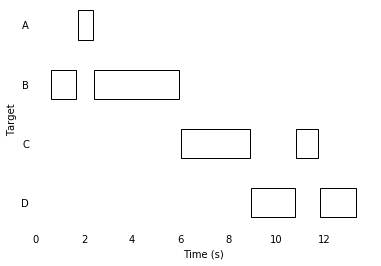

In [451]:
plt.bar(x, height, width, bottom, align='edge', fill=False)
plt.xlabel('Time (s)')
plt.ylabel('Target')
ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.yaxis.set_ticks([1.25,2.25,3.25,4.25]) # set y-ticks
ax.yaxis.tick_left()                    # remove right y-Ticks
ax.set_yticklabels(labels, fontdict=None, minor=False)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remove all the ticks and directly label each bar with respective value
plt.tick_params(top='off', bottom='off', left='off', right='off', labelbottom='on')

### define function to plot gaze for each subject

In [458]:
def plotGazeTimeline(df, subj, day, tr, axId):
    # identify this trial
    x = df.loc[(df.Subject == subj) & (df.Day == day) & (df.Trial == tr)].fixOn
    width = df.loc[(df.Subject == subj) & (df.Day == day) & (df.Trial == tr)].fixLen
    bottom = df.loc[(df.Subject == subj) & (df.Day == day) & (df.Trial == tr)].Position
    height = [0.5] * len(x)

    labels = ['Far Left','Left','Right','Far Right']
    catColor = df.loc[(df.Subject == subj) & (df.Day == day) & (df.Trial == tr)].catCode
    mycolors = ['#d7191c','#fdae61','#abdda4','#2b83ba']
    colorlist = [mycolors[x] for x in catColor-1]
    
    if axId.ndim == 1:
        axId[tr-1].bar(x, height, width, bottom, align='edge', color=colorlist, label=catColor)
    else:
        axId[tr-1, day-1].bar(x, height, width, bottom, align='edge', color=colorlist, label=catColor)
    
    ax=plt.gca()                            # get the axis
    ax.set_ylim([0.75,4.75])
    ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
    ax.yaxis.set_ticks([1.25,2.25,3.25,4.25]) # set y-ticks
    ax.yaxis.tick_left()                    # remove right y-Ticks
    ax.set_yticklabels(labels, fontdict=None, minor=False)
    xlims = ax.get_xlim()
    ax.set_xlim([0,xlims[1]])
    
    #for spine in plt.gca().spines.values():
     #   spine.set_visible(False)

    # remove all the ticks
    plt.tick_params(top='off', right='off', labelbottom='on')

### plot all trials for all days for one subject

In [459]:
# plotGazeTimeline(gaze_df, 1, 1, 2, 1)
width = 8
height = 12
fig, ax = plt.subplots(nrows=10, ncols=3, sharex=True, sharey=True, figsize=(width, height))

sbj = 4
figName = '/Users/jc/Documents/GitHub/shootGaze/figs/s' + str(sbj) + 'gaze.png'

for dy in range(1,4):
    for tr in range(1,11):
        plotGazeTimeline(gaze_df, sbj, dy, tr, ax)

ax[0, 0].set_title('Day 1')
ax[0, 1].set_title('Day 2')
ax[0, 2].set_title('Day 3')
ax[9, 0].set_xlabel('Time (s)')
ax[9, 1].set_xlabel('Time (s)')
ax[9, 2].set_xlabel('Time (s)')

patch1 = mpatches.Patch(color='#d7191c', label='A')
patch2 = mpatches.Patch(color='#fdae61', label='B')
patch3 = mpatches.Patch(color='#abdda4', label='C')
patch4 = mpatches.Patch(color='#2b83ba', label='D')

plt.legend(handles=[patch1,patch2,patch3,patch4],
           bbox_to_anchor=(0.95, 0.95),
           loc=1, ncol=4,
           bbox_transform=plt.gcf().transFigure,
           fontsize=8)

# # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
#plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)

# Tight layout often produces nice results but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.savefig(figName)
# plt.show()
plt.close(fig)

### plot all trials for each day

In [463]:
# plotGazeTimeline(gaze_df, 1, 1, 2, 1)
width = 8
height = 12
sbj = 4

for dy in range(1,4):
    fig, ax = plt.subplots(nrows=10, ncols=1, sharex=True, sharey=True, figsize=(width, height))
    figName = '/Users/jc/Documents/GitHub/shootGaze/figs/s' + str(sbj) + 'day' + str(dy) + 'gaze.png'
    for tr in range(1,11):
        plotGazeTimeline(gaze_df, sbj, dy, tr, ax)

    ax[0].set_title('Day ' + str(dy))
    ax[9].set_xlabel('Time (s)')

    patch1 = mpatches.Patch(color='#d7191c', label='A')
    patch2 = mpatches.Patch(color='#fdae61', label='B')
    patch3 = mpatches.Patch(color='#abdda4', label='C')
    patch4 = mpatches.Patch(color='#2b83ba', label='D')

    plt.legend(handles=[patch1,patch2,patch3,patch4],
               bbox_to_anchor=(0.95, 0.95),
               loc=1, ncol=4,
               bbox_transform=plt.gcf().transFigure,
               fontsize=8)

    # # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
    #plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
    #plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)

    # Tight layout often produces nice results but requires the title to be spaced accordingly
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

    #fig.savefig(figName)
    plt.savefig(figName)
    #plt.show()
    plt.close(fig)